## Notebook Configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install scikit-learn lightgbm pandas matplotlib

  Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached lightgbm-4.3.0-py3-none-win_amd64.whl.metadata (19 kB)
  Using cached pandas-2.2.2-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.8.4-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached scipy-1.13.0-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.4.0-py3-none-any.whl.metadata (13 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.2.1-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp311-cp311-win_amd64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using 

In [3]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
from sklearn import set_config
set_config(transform_output="pandas")
set_config(display='diagram')

## Necessary imports

In [5]:
import pandas as pd
import numpy as np
from utilities import *
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

## Load Data

In [6]:
X_train, y_train, X_test, y_test = load_data()

## Preprocess experiments

In [7]:
model_errors = {}
regresion_function = DecisionTreeRegressor()

### Baseline

Simple model which is baseline for future experiments  
Pipeline split data into discrete and continous columns  
For numerical data fill Nan cells with 0  
For categorical data fill Nan cells with "missing" category and aplly Label Encoder  

In [8]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', CategoricalEncoder())
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["1.baseline"] = test_model(model, X_train, y_train, X_test, y_test)

### Remove Null and corellated columns

Add ColumnDropperTransformer() which remove:
- "Id" column
- columns correlated to another in dataset with low correlation to target - 'GarageArea', "GarageYrBlt", 'TotRmsAbvGrd', "1stFlrSF"
- columns with Null-s in more that 90% of raws

In [9]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', CategoricalEncoder())
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('column_dropper', ColumnDropperTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["2.-columns"] = test_model(model, X_train, y_train, X_test, y_test)

### Add One Hot Encoder

Change discrete columns encoder to OneHotEncoder

In [10]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('column_dropper', ColumnDropperTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["3.+OneHotEncoder"] = test_model(model, X_train, y_train, X_test, y_test)

### Normalize numeric data with MinMax

Normalize continuous columns with MinMax

In [11]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('normalizer', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('column_dropper', ColumnDropperTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["4.+numNormalize"] = test_model(model, X_train, y_train, X_test, y_test)

### Remove outliers

Specifies the minimum frequency below which a category will be considered infrequent to 0.001  
Specifies an upper limit to the number of output features for each input categorical feature to 10  
Continous data points that are lesser than the 0.1th percentile are replaced with  
the 0.1th percentile value and the data points that are greater than the 99.9th  
percentile are replaced with 99.9th percentile value.

In [12]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop="if_binary", max_categories=10, min_frequency=0.001, sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('remove_outliers', OutlierTransformer()),
    ('normalizer', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('column_dropper', ColumnDropperTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["5.-outliers"] = test_model(model, X_train, y_train, X_test, y_test)

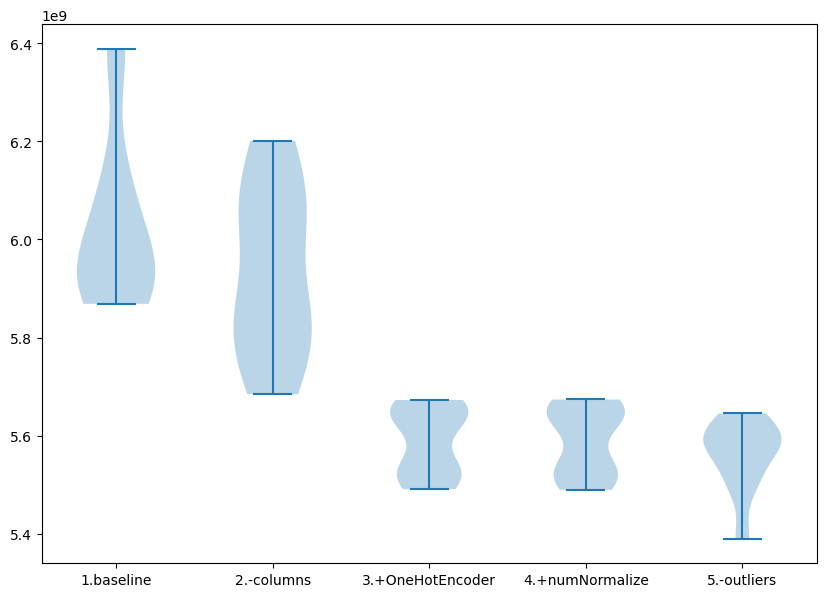

In [13]:
compare_errors(model_errors)